# Entrega laboratorio 6
## Integrantes 

- Javier Steven Barrera Toro - 202214779
- Julian Santiago Rolon Toloza - 202215839

In [15]:
from matplotlib import pyplot as plt
from typing import List, Tuple, NewType
import numpy as np
import pandas as pd
import sympy as sp
import random
import math
import copy
import tabulate
from matplotlib.colors import ListedColormap

np.seterr(divide='ignore')

{'divide': 'ignore', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

# Problema 1

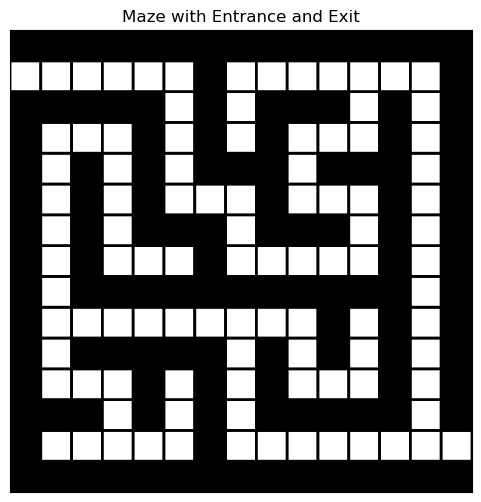

In [16]:
def load_maze(file):
    maze = np.loadtxt(file, dtype=int)
    return maze

def display_maze(maze):
    cmap = ListedColormap(['white', 'black', 'green', 'black'])
    plt.figure(figsize=(6, 6))
    plt.pcolor(maze[::-1], cmap=cmap, edgecolors='k', linewidths=2)
    plt.gca().set_aspect('equal')
    plt.xticks([])
    plt.yticks([])
    plt.title('Maze with Entrance and Exit')
    plt.show()

maze = load_maze('maze_case_base.txt')
display_maze(maze)

In [17]:
maze

array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1],
       [1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1],
       [1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1],
       [1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1],
       [1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1],
       [1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1],
       [1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1],
       [1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1],
       [1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1],
       [1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1],
       [1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1],
       [1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])

In [18]:
def generate_population(size, genome_length):
    """
    Genera una población inicial de cromosomas (individuos).

    Args:
    size (int): El número de individuos en la población.
    genome_length (int): La longitud de cada cromosoma (número de movimientos).
    
    Returns:
    list: Una lista de listas, donde cada lista interna representa
          un cromosoma con movimientos aleatorios (0: abajo, 1: arriba,
          2: izquierda, 3: derecha).
    """
    population = []
    opposite = {
        1: 0,
        0: 1,
        2: 3,
        3: 2
    }
    for _ in range(size):
        # generates individuals without backtracking
        individual = [random.randint(0,3) for _ in range(genome_length)]
        for i in range(1, len(individual)):
            gen = individual[i]
            last_gen = individual[i-1]
            if last_gen == opposite[gen]:
                if opposite[gen] in [0, 1]:
                    individual[i] = random.randint(2,3)
                else:
                    individual[i] = random.randint(0,1)
        population.append(individual)
    return population

In [19]:
def manhattan_distance(p1, p2):
    return abs(p2[1] - p1[1]) + abs(p2[0] - p1[0])

def reward(individual, maze, start, end):
    rows, cols = maze.shape
    current_row, current_col = start
    
    successful_moves = 0
    
    unique_visited_cells = set()
    unique_visited_cells.add(start)
    
    path_taken = [start]
    revisit_path_penalty_count = 0

    reached = False
    blocked = False

    moves = {0: (1, 0), 1: (-1, 0), 2: (0, -1), 3: (0, 1)}
    opposite_move = {0: 1, 1: 0, 2: 3, 3: 2}

    # verify the path in the maze
    for i, move_gene in enumerate(individual):
        move_delta = moves.get(move_gene)

        dr, dc = move_delta
        next_row, next_col = current_row + dr, current_col + dc
        next_pos = (next_row, next_col)

        # out of the maze or in some block
        if not (0 <= next_row < rows and 0 <= next_col < cols) \
                or maze[next_row, next_col] == 1:
            blocked = True
            break
        
        if next_pos in path_taken:
            revisit_path_penalty_count += 1

        current_row, current_col = next_row, next_col
        path_taken.append(next_pos)
        unique_visited_cells.add(next_pos)
        successful_moves += 1

        if next_pos == end:
            reached = True
            break

    final_pos = (current_row, current_col) 
    progress = abs(manhattan_distance(start, end) - manhattan_distance(final_pos, end))

    # - distancia
    fitness = - successful_moves * 3 + progress * 3 + len(unique_visited_cells) * 3 \
        - int(blocked) * 3 - revisit_path_penalty_count * 3 \
        if not reached else 1000 - successful_moves * 3

    return fitness
    

In [20]:
def select(population, fitnesses, elitism):
    num_items = math.ceil(len(population)*elitism)
    elements = list(zip(population, fitnesses))
    sorted_population = sorted(elements, key=lambda x: x[1], reverse=True)
    return [sorted_population[i][0] for i in range(num_items)]

def crossover(parent1, parent2):
    genome_length = len(parent1)
    crossover_point = math.ceil(genome_length * 0.55)

    child1 = parent1[:crossover_point] + parent2[crossover_point:]
    child2 = parent2[:crossover_point] + parent1[crossover_point:]
    
    return child1, child2

def mutate(individual, mutation_rate):
    genome_length = len(individual)
    opposite = {0: 1, 1: 0, 2: 3, 3: 2}

    genes = [g for g in range(random.randint(1, genome_length))]

    # mutate a different number of genes
    for i in genes:
        gen = individual[i]
        # evit mutate with backtracking solutions
        if random.random() <= mutation_rate:
            if i > 0 and gen == opposite.get(individual[i-1]):
                individual[i] = random.randint(2,3) if gen in [0, 1] else random.randint(0,1)
            else:
                individual[i] = random.randint(0, 3)

    return individual


In [21]:
def evolve(population, maze, start, end):
    rewards = [reward(individual, maze, start, end) for individual in population]

    elite_individuals = select(population, rewards, elitism)
    k = len(elite_individuals)
    N = len(population)
    num_offspring_needed = N - k

    children = []

    min_reward = min(rewards) if rewards else 0
    weights = [max(0.005, r - min_reward) for r in rewards]
    total_weight = sum(weights)

    mating_pool = []
    if total_weight > 0:
        mating_pool = random.choices(
            population,
            weights=weights,
            k=num_offspring_needed
        )
    else:
        mating_pool = random.choices(population, k=num_offspring_needed)

    num_pairs = num_offspring_needed // 2
    for i in range(num_pairs):
        parent1 = mating_pool[i*2]
        parent2 = mating_pool[i*2 + 1]
        child1, child2 = crossover(parent1, parent2)
        children.append(child1)
        children.append(child2)

    if len(elite_individuals) + len(children) < N:
         if elite_individuals:
              children.append(list(elite_individuals[0]))
         elif mating_pool:
              children.append(list(mating_pool[0]))

    mutated_children = [mutate(child, mutation_rate) for child in children]
    new_population = elite_individuals + mutated_children

    return new_population

In [22]:
def get_10_best_fitnesses(population, maze, origin, goal):
    rewards = [reward(individual, maze, origin, goal) for individual in population]
    population_with_rewards = zip(population, rewards)
    sorted_population = sorted(population_with_rewards, key=lambda x: x[1], reverse=True)
    return [rew for pop, rew in sorted_population][:10], [pop for pop, rew in sorted_population][:10]

In [23]:
N = 200
elitism = 0.02
k = math.ceil(N * elitism)
length = 50
origin = (1, 0)
goal = (13, 14)
mutation_rate = 0.25

random.seed(42)

base_population = []
last_population = []

population = generate_population(N, length)
print(f"best fitness for the initial population {get_10_best_fitnesses(population, maze, origin, goal)[0]}")

generation = 1
max_gens = 300
best_solution = []
while generation <= max_gens:
    population = evolve(population, maze, origin, goal)
    if generation % 50 == 0:
        print(f"#### Epoch {generation} ####")
        best, pop = get_10_best_fitnesses(population, maze, origin, goal)
        best_solution = pop[0]
        print(f"5 best fitness {list(map(lambda x: round(x, 2), best))}")
    generation += 1

best fitness for the initial population [12, 12, 9, 9, 9, 6, 6, 6, 6, 6]
#### Epoch 50 ####
5 best fitness [27, 27, 27, 27, 27, 27, 24, 24, 21, 21]
#### Epoch 100 ####
5 best fitness [42, 42, 42, 42, 42, 21, 21, 12, 12, 12]
#### Epoch 150 ####
5 best fitness [51, 51, 51, 48, 48, 45, 42, 33, 30, 30]
#### Epoch 200 ####
5 best fitness [51, 51, 51, 51, 51, 51, 27, 24, 24, 21]
#### Epoch 250 ####
5 best fitness [51, 51, 51, 51, 51, 51, 36, 27, 21, 18]
#### Epoch 300 ####
5 best fitness [51, 51, 51, 51, 51, 24, 18, 18, 18, 18]


[3, 3, 3, 3, 3, 0, 0, 0, 0, 3, 3, 0, 0, 3, 3, 3, 3, 3, 1, 2, 1, 3, 2, 0, 1, 3, 1, 0, 0, 0, 1, 1, 0, 2, 3, 3, 1, 3, 0, 2, 3, 1, 0, 0, 3, 3, 1, 2, 2, 2]
[!] ILEGAL MOVEMENT: in block or outside of the maze


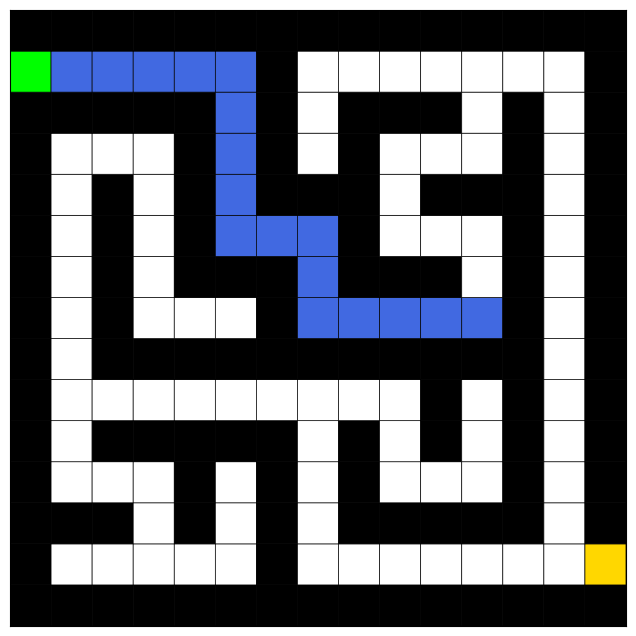

In [24]:
def display_maze_with_path(maze, individual, start, end):
  """
  Muestra el laberinto y opcionalmente superpone un camino de solución.

  Args:
      maze (np.array): El array 2D NumPy para el laberinto (0=camino, 1=muro).
      individual (list, optional): Secuencia de movimientos (0,1,2,3) para el camino. Por defecto None.
      start (tuple, optional): Coordenadas de inicio (fila, col). Necesario si se provee individual. Por defecto None.
      end (tuple, optional): Coordenadas de fin (fila, col). Usado para marcar el punto final. Por defecto None.
      title_suffix (str, optional): Sufijo para añadir al título del gráfico.
  """
  cmap = ListedColormap(['white', 'black', 'royalblue', 'lime', 'gold'])
  maze_display = maze.copy().astype(float) # Usar float permite marcadores no enteros si fuera necesario

  path_coords = []

  if individual is not None and start is not None:
    rows, cols = maze.shape
    current_row, current_col = start
    if not (0 <= start[0] < rows and 0 <= start[1] < cols and maze[start[0], start[1]] == 0):
         print(f"Advertencia: El punto de inicio {start} no es válido en el laberinto.")
    else:
        path_coords.append(start)

    moves = {
        0: (1, 0),  # Abajo
        1: (-1, 0), # Arriba
        2: (0, -1), # Izquierda
        3: (0, 1)   # Derecha
    }

    for move_gene in individual:
        dr, dc = moves.get(move_gene, (0, 0))
        next_row, next_col = current_row + dr, current_col + dc

        if not (0 <= next_row < rows and 0 <= next_col < cols) or maze[next_row, next_col] == 1:
            print("[!] ILEGAL MOVEMENT: in block or outside of the maze")
            break
            # return

        current_row, current_col = next_row, next_col
        path_coords.append((current_row, current_col))

        if end is not None and (current_row, current_col) == end:
            print("[!] ILEGAL MOVEMENT: end reached")
            break
            #return

  path_cells_to_mark = [p for p in path_coords if p != start and p != end]
  for r, c in path_cells_to_mark:
      maze_display[r, c] = 2 # 2 representa el camino de la solución (azul)

  # Marcar el inicio con el valor 3 (verde lima)
  if start is not None and 0 <= start[0] < rows and 0 <= start[1] < cols:
      maze_display[start[0], start[1]] = 3

  # Marcar el fin con el valor 4 (rojo)
  if end is not None and 0 <= end[0] < rows and 0 <= end[1] < cols:
      maze_display[end[0], end[1]] = 4

  plt.figure(figsize=(8, 8))
  norm = plt.cm.colors.BoundaryNorm(np.arange(-0.5, 5.5, 1), cmap.N)
  plt.pcolor(maze_display[::-1], cmap=cmap, edgecolors='k', linewidths=0.5, norm=norm)

  plt.gca().set_aspect('equal')
  plt.xticks([])
  plt.yticks([])
  plt.show()

print(best_solution)
display_maze_with_path(maze, pop[4], origin, goal)

In [25]:
def generate_population_v2(size, genome_length):
    """
    Genera una población inicial de cromosomas (individuos).

    Args:
    size (int): El número de individuos en la población.
    genome_length (int): La longitud de cada cromosoma (número de movimientos).
    
    Returns:
    list: Una lista de listas, donde cada lista interna representa
          un cromosoma con movimientos aleatorios (0: adelante, 1: ,
          2: izquierda, 3: derecha).
    """
    population = []

    directions = {0: (0, 1), 1: (0, -1), 2: (1, 0), 3: (-1, 0)}
    opposite = {
        1: 2,
        2: 1
    }
    random_pop = size # // 2
    # heuristic_pop = size - random_pop
    
    # generate random population
    for _ in range(random_pop):
        individual = [random.randint(0, 2) for _ in range(genome_length)]
        for i, gen in enumerate(individual):
            last_gen = individual[i-1]
            if last_gen == gen and last_gen != 0:
                if gen == 1:
                    individual[i] = 2
                else:
                    individual[i] = 1
                    
        population.append(individual)
    
    # for _ in range(size):
    #     # generates individuals without backtracking
    #     individual = [random.randint(0,3) for _ in range(genome_length)]
    #     for i in range(1, len(individual)):
    #         gen = individual[i]
    #         last_gen = individual[i-1]
    #         if last_gen == opposite[gen]:
    #             if opposite[gen] in [0, 1]:
    #                 individual[i] = random.randint(2,3)
    #             else:
    #                 individual[i] = random.randint(0,1)
    #     population.append(individual)
    return population


## IMPLEMENTACIÓN 2

In [26]:
class Orientation:
    def __init__(self, right: int):
        self.degrees = 0 # 0 degrees
        self.right = right
        self.left = right + 1
        self.movement = {0: (0, 1), 90: (-1, 0), 180: (0, -1), 270: (1, 0)}

    def rotate(self, direction: int):
        if direction not in [self.right, self.left]:
            raise Exception(f"ERROR: DIRECTION NOT FOUND: {direction}")
        if direction == self.right:
            return self.__right_rotation()
            
        return self.__left_rotation()

    def evaluate(self):
        return self.movement.get(self.degrees)

    def reset_orientation(self):
        self.degrees = 0

    def __right_rotation(self):
        self.degrees = (self.degrees + 270) % 360
        return self.movement.get(self.degrees)

    def __left_rotation(self):
        self.degrees = (self.degrees + 90) % 360
        return self.movement.get(self.degrees)

    def __str__(self):
        return str(self.degrees)


In [258]:
class ProblemParams:
    def __init__(self, maze, start, end):
        self.maze = maze
        self.start = start
        self.end = end

    def get(self):
        return [self.maze, self.start, self.end]

class Individual:
    def __init__(self, steps, params: ProblemParams):
        self.steps = steps
        self.length = len(steps)
        self.orientation = Orientation(1)
        self.itr_orientation = Orientation(1)
        self.fitness = self.calculate_reward(*params.get())
        self.params = params
    
    # problem: 0 0 is also a valid solution if there exists an intersection
    def crossover(self, individual):
        inf = math.ceil(self.length * 0.4)
        sup = math.ceil(self.length * 0.6)
        crosspoint = random.randint(inf, sup)
        steps1, steps2 = [], []
        
        if self.steps[crosspoint] != individual.steps[crosspoint]:
            steps1 = self.steps[:crosspoint] + individual.steps[crosspoint+1:] + [individual.steps[crosspoint]]
            steps2 = individual.steps[:crosspoint] + self.steps[crosspoint+1:] + [self.steps[crosspoint]]
        else:
            steps1 = self.steps[:crosspoint] + individual.steps[crosspoint:]
            steps2 = individual.steps[:crosspoint] + self.steps[crosspoint:]

        i1 = Individual(steps1, self.params)
        i2 = Individual(steps2, self.params)
        return i1, i2

    def calculate_reward(self, maze, origin, end):
        curr = origin
        path = [origin]
        unique = set(origin)
        self.itr_orientation.reset_orientation()
        delta = self.itr_orientation.evaluate()

        def manhattan_distance(p1, p2):
            return abs(p1[0] - p2[0]) + abs(p1[1] - p2[1])

        def see_paths(i, j, maze):
            empty_paths = 0
            if i + 1 < maze.shape[0] and maze[i + 1, j] == 0: empty_paths += 1
            elif 0 <= i - 1 and maze[i - 1, j] == 0: empty_paths += 1
            elif j + 1 < maze.shape[1] and maze[i, j + 1] == 0: empty_paths += 1
            elif 0 <= j - 1 and maze[i, j - 1] == 0: empty_paths += 1
        
            return empty_paths
        
        fitness = 0
        opposite = {1: 2, 2: 1}
        REACHED = False
        dummie_wall = 0
        dummie_movm = 0
        uniq = 0
        for index, gen in enumerate(self.steps):
            i, j = curr
            if gen == 0:
                while (delta[0] + i < maze.shape[0] and delta[1] + j < maze.shape[1]) \
                    and see_paths(i, j, maze) < 3:
                    if maze[delta[0] + i, delta[1] + j] == 1:
                        dummie_wall += 1
                        break

                    i, j = (i + delta[0], j + delta[1])
                    path.append((i, j))
                    if (i,j) in unique:
                        uniq -= 1
                    else:
                        unique.add((i,j))
                        uniq += 1

                    if (i,j) == end:
                        REACHED = True
                        break
                curr = i, j
            else:
                delta = self.itr_orientation.rotate(gen)
                if index > 0:
                    if opposite.get(gen) == gen:
                        dummie_movm += 1
                    if [self.steps[i-1], gen, self.steps[i+1]] in [[1, 1, 1], [2, 2, 2]]:
                        dummie_movm += 1

            if REACHED: break

        fitness += uniq * 15 # exploration
        fitness -= manhattan_distance(path[-1], end)*10 # distance
        fitness -= (dummie_movm + dummie_wall) * 8
        fitness += 5000 if REACHED else 0 
        return fitness
    
    # mutate to generate solutions like 0 0
    def mutate(self, mutation_rate):
        # change from 1,2 -> 2,1 at least mutation_rate * self.length
        # right shift
        gen_mutate = math.ceil(mutation_rate * self.length)
        for i, gen in enumerate(self.steps):
            if random.random() < mutation_rate:
                if gen != 0:
                    self.steps[i] = random.randint(1,2)
                # if gen != 0:
                #     self.steps[i] = random.choices([0, 1, 2], weights=[0.6, 0.2, 0.2], k=1)[0]
                # else:
                #     self.steps[i] = random.choices([0, 1, 2], weights=[0.2, 0.4, 0.4], k=1)[0]

        return self

    def set_off_fitness(self, value):
        self.fitness += value
    
    def __str__(self):
        return f"Individual(steps={self.steps}, orientation={self.orientation}, fit={round(self.fitness, 2)})"

    def __repr__(self):
        return self.__str__()

    def __add__(self, other):
        indv = Individual([], self.params)
        indv.fitness = self.fitness + other.fitness
        return indv

    @classmethod
    def zero(cls):
        return Individual([], self.params)
    
    def __radd__(self, other):
        if other == 0:
            return self
        return self.__add__(other)

In [270]:
class GAlgorithm:
    def __init__(self, poblation: int, elitism: float, individual_length: int, mutation_rate: float, generations, params: ProblemParams):
        self.size = poblation
        self.elitism = elitism
        self.length = individual_length
        self.maze, self.origin, self.goal = params.get()
        self.mutation_rate = mutation_rate
        self.generations = generations

        self.__population = None
        self.sorted = False
        self.history = []
        self.params = params

    def sort_population(self):
        self.__population = sorted(self.__population, key=lambda ind: ind.fitness, reverse=True)
        self.sorted = True

    def get_10_best_fitnesses(self):
        subset = self.__population[:10]
        rewards = list(map(lambda s: round(s.fitness, 2), subset))
        paths = list(map(lambda p: p.steps, subset))

        return rewards, paths

    def roulette(self):
        pass
    
    def select(self):
        num_elitist = math.ceil(self.elitism * self.size)
        num_non_elitist = self.size - num_elitist
        
        elitist = self.__population[:num_elitist]
        non_elitist = self.__population[num_elitist:]

        # seleccionar los nuevos padres de los no elitistas basados de alguna manera
        _min = self.__population[-1].fitness # already sorted
        offset = abs(_min) + 1e-2
        for i in range(num_non_elitist):
            non_elitist[i].set_off_fitness(offset)

        total_fitness = sum(non_elitist).fitness
        pr = list(map(lambda el: el.fitness / total_fitness, non_elitist))

        parents = random.choices(non_elitist, weights=pr, k=num_non_elitist)

        # producir los hijos
        offspring = []
        for i in range(0, num_non_elitist):
            indv1, indv2 = random.choices(non_elitist, weights=pr, k=2)

            #rindv1, rindv2 = non_elitist[i].crossover(non_elitist[i+1])

            rindv1, rindv2 = indv1.crossover(indv2)
            offspring += [rindv1, rindv2]

        # mutar los seleccionados
        offspring = list(map(lambda indiv: indiv.mutate(self.mutation_rate), offspring))

        self.__population = elitist + offspring[:num_non_elitist]
        self.sort_population()
        return self.__population
    
    # ok but...
    # problem: 0 0 is also a valid solution if there exists an intersection. This doesn't generates it
    def generate_population(self):
        population = []

        directions = {0: (0, 1), 1: (0, -1), 2: (1, 0), 3: (-1, 0)}
        opposite = {
            1: 2,
            2: 1
        }
        random_pop = self.size
        
        for i in range(self.size):
            first_element = random.randint(0,2)
            r = self.length - 1
            indiv = [(random.randint(1,2), 0) for j in range(math.ceil(r/2))] \
                if first_element == 0 \
                else [(0, [1,2][random.randint(0,1)]) for i in range(math.ceil(r/2))]

            steps = [first_element]
            for gen in indiv:
                steps += list(gen)

            diff = len(steps) - self.length
            if diff > 0:
                steps = steps[:len(steps) - diff]

            population.append(Individual(steps, self.params))

        self.__population = population
        self.__history = [self.__population]
        self.sort_population()

        return self.__population

    def evolve(self) -> Individual:
        if self.__population is None:
            self.__population = self.generate_population()
            self.__history = [self.__population]

        rounded = list(map(lambda x: round(x, 2), self.get_10_best_fitnesses()[0]))
        print(f"best fitness for the initial population {rounded}")
        
        generation = 1
        best_solution = []

        while generation <= self.generations:
            self.__population = self.select()
            if generation % 50 == 0:
                print(f"#### Epoch {generation} ####")
                best, pop = self.get_10_best_fitnesses()
                best_solution = best[0], pop[0]
                print(f"10 best fitness {best}")

            generation += 1

        print("\n######## BEST SOLUTION ########")
        print(f"\t[->] PATH: {best_solution[1]}")
        print(f"\t[->] REWARD: {best_solution[0]}")

        return self.__population

In [271]:
params = ProblemParams(maze, (1,0), (13,14))

alg = GAlgorithm(
    poblation=200,
    elitism=0.02,
    individual_length=35,
    mutation_rate=0.5,
    params=params,
    generations=300
)
population = alg.generate_population()
solution = alg.evolve()
#print(solution)
#print(solution.calculate_reward(maze, origin, goal))

best fitness for the initial population [189, 131, 111, 101, 51, 41, 41, 39, 31, 21]
#### Epoch 50 ####
10 best fitness [5502, 5494, 541, 491, 127, 83, 67, 67, 65, 65]
#### Epoch 100 ####
10 best fitness [5502, 5494, 541, 491, 103, 97, 91, 89, 87, 87]
#### Epoch 150 ####
10 best fitness [5502, 5494, 541, 491, 113, 103, 103, 103, 103, 103]
#### Epoch 200 ####
10 best fitness [5502, 5494, 541, 491, 123, 113, 113, 103, 103, 103]
#### Epoch 250 ####
10 best fitness [5502, 5494, 541, 491, 113, 103, 103, 103, 103, 103]
#### Epoch 300 ####
10 best fitness [5502, 5494, 541, 491, 123, 113, 103, 103, 103, 103]

######## BEST SOLUTION ########
	[->] PATH: [0, 1, 0, 2, 0, 1, 0, 1, 0, 1, 0, 1, 0, 2, 0, 2, 0, 1, 0, 1, 0, 2, 0, 1, 0, 1, 0, 2, 0, 1, 0, 2, 0, 2, 0]
	[->] REWARD: 5502


In [274]:
def display_maze_with_path(maze, solution, start, end):
    cmap = ListedColormap(['white', 'black', 'royalblue', 'lime', 'gold'])
    maze_display = maze.copy().astype(float)
    rows, cols = maze.shape

    if not (0 <= start[0] < rows and 0 <= start[1] < cols and maze[start[0], start[1]] == 0):
        print(f"Advertencia: El punto de inicio {start} no es válido en el laberinto.")
        return

    # paths
    def see_paths(i, j, maze):
        empty_paths = 0
        if i + 1 <= maze.shape[0] and maze[i + 1, j] == 0: empty_paths += 1
        elif 0 <= i - 1 and maze[i - 1, j] == 0: empty_paths += 1
        elif j + 1 <= maze.shape[1] and maze[i, j + 1] == 0: empty_paths += 1
        elif 0 <= j - 1 and maze[i, j - 1] == 0: emplty_paths += 1
    
        return empty_paths

    path_coords = [start]
    curr = start
    solution.itr_orientation.reset_orientation()
    delta = solution.itr_orientation.evaluate()
    for gen in solution.steps:
        if gen == 0:
            i, j = curr
    
            while (delta[0] + i < maze.shape[0] and delta[1] + j < maze.shape[1]) \
                and maze[delta[0] + i, delta[1] + j] != 1 and see_paths(i, j, maze) < 3:
                i, j = (i + delta[0], j + delta[1])
                path_coords.append((i, j))
    
                if (i,j) == goal:
                   print("THE SOLUTION REACHED THE END!")
                   break
    
            curr = i, j
        else:
            delta = solution.itr_orientation.rotate(gen)

    # mark the path with blue blocks
    path_cells_to_mark = [el for el in path_coords if el != start and el != end]
    for r, c in path_cells_to_mark:
        maze_display[r, c] = 2

    # mark the start as green
    if start is not None and 0 <= start[0] < rows and 0 <= start[1] < cols:
        maze_display[start[0], start[1]] = 3

    # mark the end as gold
    if end is not None and 0 <= end[0] < rows and 0 <= end[1] < cols:
        maze_display[end[0], end[1]] = 4

    # graph
    plt.figure(figsize=(max(8, cols / 2), max(8, rows / 2)))
    norm = plt.cm.colors.BoundaryNorm(np.arange(-0.5, 5.5, 1), cmap.N)
    plt.pcolor(maze_display[::-1], cmap=cmap, edgecolors='k', linewidths=0.5, norm=norm)

    plt.title(f"Laberinto con Camino del Individuo")
    plt.gca().set_aspect('equal')
    plt.xticks([])
    plt.yticks([])
    plt.show()

#print(solution)
#display_maze_with_path(maze, solution, origin, goal)
#solution.calculate_reward(maze, origin, goal)
_min = -np.inf
sol = 0
for indv in solution:
    if indv.fitness > _min:
        _min = indv.fitness
        sol = indv
print(sol)
sol.calculate_reward(maze, origin, goal)

Individual(steps=[0, 1, 0, 2, 0, 1, 0, 1, 0, 1, 0, 1, 0, 2, 0, 2, 0, 1, 0, 1, 0, 2, 0, 1, 0, 1, 0, 2, 0, 1, 0, 2, 0, 2, 0], orientation=0, fit=5502)


-209

In [181]:
maze
curr = origin
history = [curr]
solution.itr_orientation.reset_orientation()
delta = solution.itr_orientation.evaluate()

print(maze)

def see_paths(i, j, maze):
    empty_paths = 0
    if i + 1 <= maze.shape[0] and maze[i + 1, j] == 0: empty_paths += 1
    elif 0 <= i - 1 and maze[i - 1, j] == 0: empty_paths += 1
    elif j + 1 <= maze.shape[1] and maze[i, j + 1] == 0: empty_paths += 1
    elif 0 <= j - 1 and maze[i, j - 1] == 0: emplty_paths += 1

    return empty_paths

for gen in solution.steps:
    if gen == 0:
        i, j = curr

        while (delta[0] + i < maze.shape[0] and delta[1] + j < maze.shape[1]) \
            and maze[delta[0] + i, delta[1] + j] != 1 and see_paths(i, j, maze) < 3:
            i, j = (i + delta[0], j + delta[1])
            history.append((i, j))

            if (i,j) == goal:
               print("REACHED")
               break

        curr = i, j
    else:
        delta = solution.itr_orientation.rotate(gen)

print(history)

[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 1 0 0 0 0 0 0 0 1]
 [1 1 1 1 1 0 1 0 1 1 1 0 1 0 1]
 [1 0 0 0 1 0 1 0 1 0 0 0 1 0 1]
 [1 0 1 0 1 0 1 1 1 0 1 1 1 0 1]
 [1 0 1 0 1 0 0 0 1 0 0 0 1 0 1]
 [1 0 1 0 1 1 1 0 1 1 1 0 1 0 1]
 [1 0 1 0 0 0 1 0 0 0 0 0 1 0 1]
 [1 0 1 1 1 1 1 1 1 1 1 1 1 0 1]
 [1 0 0 0 0 0 0 0 0 0 1 0 1 0 1]
 [1 0 1 1 1 1 1 0 1 0 1 0 1 0 1]
 [1 0 0 0 1 0 1 0 1 0 0 0 1 0 1]
 [1 1 1 0 1 0 1 0 1 1 1 1 1 0 1]
 [1 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]]
[(1, 0), (1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (2, 5), (3, 5), (4, 5), (5, 5), (4, 5), (3, 5), (2, 5), (1, 5), (1, 4), (1, 3), (1, 2), (1, 1), (1, 0), (1, 1), (1, 2), (1, 3), (1, 4), (1, 5)]
